# [DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter](https://arxiv.org/abs/1910.01108)

In this lecture, we will explore the architecture of DistilBERT, its key components, and how it can be utilized for various natural language processing tasks. Additionally, we'll discuss its advantages, limitations, and provide hands-on examples to showcase its effectiveness.

Reference : [The Theory](https://towardsdatascience.com/distillation-of-bert-like-models-the-code-73c31e8c2b0a) | [Code](https://towardsdatascience.com/distillation-of-bert-like-models-the-theory-32e19a02641f)

In [1]:
# import os
# # Set GPU device
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# os.environ['http_proxy']  = 'http://192.41.170.23:3128'
# os.environ['https_proxy'] = 'http://192.41.170.23:3128'

In [2]:
# !pip install datasets --upgrade
import datasets
import transformers
import torch
datasets.__version__, transformers.__version__, torch.__version__

/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


('3.1.0', '4.36.2', '2.4.1')

In [3]:
import torch.nn as nn
import torch
from tqdm.auto import tqdm
import random, math, time

device = torch.device('mps')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

mps


## 1. Loading our MNLI part of the GLUE dataset

In [4]:
from datasets import load_dataset
raw_datasets = load_dataset("wisnu001binus/Hate_Speech_Dataset")
print("Dataset structure:", raw_datasets)
print("Dataset columns:", raw_datasets["train"].column_names)

Repo card metadata block was not found. Setting CardData to empty.


Dataset structure: DatasetDict({
    train: Dataset({
        features: ['Content', 'Label'],
        num_rows: 580895
    })
    test: Dataset({
        features: ['Content', 'Label'],
        num_rows: 145224
    })
})
Dataset columns: ['Content', 'Label']


In [5]:
num_labels = len(set(raw_datasets["train"]["Label"]))
label_list = sorted(list(set(raw_datasets["train"]["Label"])))
label2id = {v: i for i, v in enumerate(label_list)}
id2label = {i: v for v, i in label2id.items()}

print(f"Number of labels: {num_labels}")
print("Label mapping:", label2id)

Number of labels: 2
Label mapping: {0: 0, 1: 1}


In [6]:
id2label = {i: v for v, i in label2id.items()}
id2label

{0: 0, 1: 1}

In [8]:
from datasets import ClassLabel
from datasets import DatasetDict
label_feature = ClassLabel(names=["non-toxic", "toxic"]) 
dataset = DatasetDict({
    "train": raw_datasets["train"].cast_column("label", label_feature),
    "validation": raw_datasets["validation"].cast_column("label", label_feature),
    "test": raw_datasets["test"].cast_column("label", label_feature),
})

## 2. Model & Tokenization

In [9]:
label_list = dataset["train"].features["label"].names
label2id = {v: i for i, v in enumerate(label_list)}
label2id

{'non-toxic': 0, 'toxic': 1}

<img src = "figures/BERT_embed.png" width=500>

In [10]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

teacher_id = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(teacher_id)

teacher_model = AutoModelForSequenceClassification.from_pretrained(
    teacher_id, 
    num_labels = num_labels,
    id2label = id2label,
    label2id = label2id,
)

teacher_model

/opt/anaconda3/envs/A6/lib/python3.8/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## 3. Preprocessing 

In [11]:
def tokenize_function(examples):
    texts = [str(text) for text in examples["text"]]
    result = tokenizer(texts, padding=False, truncation=True, max_length=32)
    return result

In [12]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 31060
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3883
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3883
    })
})

In [13]:
# list(task_to_keys[task_name])
column_dataset = [item for item in ["text"] if item == "text"]
print(column_dataset)

['text']


In [14]:
#remove column : 'premise', 'hypothesis', 'idx'
tokenized_datasets = tokenized_datasets.remove_columns(column_dataset)
#rename column : 'labels'
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 31060
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3883
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3883
    })
})

In [15]:
tokenized_datasets['train'][0]['input_ids']

tensor([ 101, 1045, 2064, 3305, 2008, 1998, 2065, 2009, 1005, 1055, 2619, 1045,
        2113, 1045, 2097, 5981, 2007, 2068, 2021, 1045, 2572, 2025, 5627, 2000,
        5247, 2008, 2172, 2051, 2667, 2000, 2689,  102])

In [16]:
tokenizer.decode(tokenized_datasets['train'][0]['input_ids'])

"[CLS] i can understand that and if it's someone i know i will debate with them but i am not willing to spend that much time trying to change [SEP]"

## 4. Preparing the dataloader

In [17]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
#Data collator that will dynamically pad the inputs received.s

In [18]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=1150).select(range(10000))
small_eval_dataset = tokenized_datasets["validation"].shuffle(seed=1150).select(range(1000))
small_test_dataset = tokenized_datasets["test"].shuffle(seed=1150).select(range(1000))

In [19]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(
    small_train_dataset, shuffle=True, batch_size=8, collate_fn=data_collator, num_workers=4)
test_dataloader = DataLoader(
    small_test_dataset, batch_size=8, collate_fn=data_collator, num_workers=4)
eval_dataloader = DataLoader(
    small_eval_dataset, batch_size=8, collate_fn=data_collator, num_workers=4)

In [20]:
for batch in train_dataloader:
    break
    
batch['labels'].shape, batch['input_ids'].shape, batch['attention_mask'].shape

/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` 

(torch.Size([8]), torch.Size([8, 32]), torch.Size([8, 32]))

## 5. Design the model and losses

### 5.1 Teacher Model & Student Model

####  Architecture 
In the present work, the student - DistilBERT - has the same general architecture as BERT. 
- The `token-type embeddings` and the `pooler` are removed while `the number of layers` is reduced by a factor of 2. 
- Most of the operations used in the Transformer architecture `linear layer` and `layer normalisation` are highly optimized in modern linear algebra frameworks.
- our investigations showed that variations on the last dimension of the tensor (hidden size dimension) have a smaller impact on computation efficiency (for a fixed parameters budget) than variations on other factors like the number of layers. 
- Thus we focus on reducing the number of layers.

#### Initialize Student Model
- To initialize a new model from an existing one, we need to access the weights of the old model (the teacher). 
- In order to get the weights, we first have to know how to access them. We’ll use BERT as our teacher model.

In [21]:
teacher_model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": 0,
    "1": 1
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "non-toxic": 0,
    "toxic": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.36.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

#### 
- The student model has the same configuration, except the number of layers is reduced by a factor of 2
- The student layers are initilized by copying one out of two layers of the teacher, starting with layer 0.
- The head of the teacher is also copied.

In [22]:
from transformers.models.bert.modeling_bert import BertPreTrainedModel, BertConfig
# Get teacher configuration as a dictionnary
configuration = teacher_model.config.to_dict()
configuration

{'return_dict': True,
 'output_hidden_states': False,
 'output_attentions': False,
 'torchscript': False,
 'torch_dtype': None,
 'use_bfloat16': False,
 'tf_legacy_loss': False,
 'pruned_heads': {},
 'tie_word_embeddings': True,
 'is_encoder_decoder': False,
 'is_decoder': False,
 'cross_attention_hidden_size': None,
 'add_cross_attention': False,
 'tie_encoder_decoder': False,
 'max_length': 20,
 'min_length': 0,
 'do_sample': False,
 'early_stopping': False,
 'num_beams': 1,
 'num_beam_groups': 1,
 'diversity_penalty': 0.0,
 'temperature': 1.0,
 'top_k': 50,
 'top_p': 1.0,
 'typical_p': 1.0,
 'repetition_penalty': 1.0,
 'length_penalty': 1.0,
 'no_repeat_ngram_size': 0,
 'encoder_no_repeat_ngram_size': 0,
 'bad_words_ids': None,
 'num_return_sequences': 1,
 'chunk_size_feed_forward': 0,
 'output_scores': False,
 'return_dict_in_generate': False,
 'forced_bos_token_id': None,
 'forced_eos_token_id': None,
 'remove_invalid_values': False,
 'exponential_decay_length_penalty': None,
 'su

In [23]:
# Half the number of hidden layer
configuration['num_hidden_layers'] //= 2
# Convert the dictionnary to the student configuration
configuration = BertConfig.from_dict(configuration)

In [24]:
# Create uninitialized student model
model = type(teacher_model)(configuration)
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

- Recursively copies the weights of the (teacher) to the (student).
- This function is meant to be first called on a BertFor... model, but is then called on every children of that model recursively.
- The only part that's not fully copied is the encoder, of which only half is copied.

In [25]:
from transformers.models.bert.modeling_bert import BertEncoder, BertModel
from torch.nn import Module

def distill_bert_weights(
    teacher : Module,
    student : Module,
    init_method : str
) -> None:
    """
    Recursively copies the weights of the (teacher) to the (student).
    This function is meant to be first called on a BertFor... model, but is then called on every children of that model recursively.
    The only part that's not fully copied is the encoder, of which only half is copied based on init_method.
    """
    # If the part is an entire BERT model or a BERTFor..., unpack and iterate
    if isinstance(teacher, BertModel) or type(teacher).__name__.startswith('BertFor'):
        for teacher_part, student_part in zip(teacher.children(), student.children()):
            distill_bert_weights(teacher_part, student_part, init_method)
    
    # Else if the part is an encoder, copy one out of every layer based on init_method
    elif isinstance(teacher, BertEncoder):
        teacher_encoding_layers = [layer for layer in next(teacher.children())]  # 12 layers
        student_encoding_layers = [layer for layer in next(student.children())]  # 6 layers
        # Odd Layers
        if init_method == 'Odd Layer':
            for i in range(len(student_encoding_layers)):
                student_encoding_layers[i].load_state_dict(teacher_encoding_layers[i*2+1].state_dict())  # Odd layers, from 1
        # Even Layers
        elif init_method == 'Even Layer':
            for i in range(len(student_encoding_layers)):
                student_encoding_layers[i].load_state_dict(teacher_encoding_layers[i*2].state_dict())  # Even layers, from 0

    # Else the part is a head or something else, copy the state_dict
    else:
        student.load_state_dict(teacher.state_dict())

    return model 

In [26]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model_types = ['Odd Layer', 'Even Layer']
print('Teacher parameters:', count_parameters(teacher_model))
for model_type in model_types:
    student_model = type(teacher_model)(configuration)     # Create a student model
    distill_bert_weights(teacher=teacher_model, student=student_model, init_method=model_type)
    print(f'Student ({model_type}) parameters:', count_parameters(student_model))

Teacher parameters: 109483778
Student (Odd Layer) parameters: 66956546
Student (Even Layer) parameters: 66956546


In [27]:
teacher_params = count_parameters(teacher_model)
def calculate_parameter_percentage(student_model, teacher_model):
    student_params = count_parameters(student_model)
    teacher_params = count_parameters(teacher_model)
    return (student_params / teacher_params) * 100

In [28]:
for model_type in model_types:
    student_model = type(teacher_model)(configuration)
    distill_bert_weights(teacher=teacher_model, student=student_model, init_method=model_type)
    percentage = calculate_parameter_percentage(student_model, teacher_model)
    print(f"Student ({model_type}): {percentage:.2f}% of the teacher model")

Student (Odd Layer): 61.16% of the teacher model
Student (Even Layer): 61.16% of the teacher model


In [29]:
#It has 61.16% less parameters than bert-base-uncased

### 5.2 Loss function

#### Softmax

$$
P_i(\mathbf{z}_i, T) = \frac{\exp(\mathbf{z}_i / T)}{\sum_{q=0}^k \exp(\mathbf{z}_q / T)}
$$


#### Knowledge Distillation

#### CE Loss
$$\mathcal{L}_\text{CE} = -\sum^N_{j=0}\sum_{i=0}^k {y}_i^{(j)}\log(P_i({v}_i^{(j)}, 1))$$

#### KL Loss
$$\mathcal{L}_\text{KD} = -\sum^N_{j=0}\sum_{i=0}^k P_i({z}_i^{(j)}, T) \log (P_i({v}_i^{(j)}, T))$$

#### Cosine Embedding Loss
$$\mathcal{L}_{\text{cosine}}(x_1, x_2, y) = \frac{1}{N} \sum_{i=1}^{N} \left(1 - y_i \cdot \cos(\theta_i)\right)$$

<!-- $$\mathcal{L} = \lambda \mathcal{L}_\text{KD} + (1-\lambda)\mathcal{L}_\text{CE}$$
 -->

#### Total Loss
$$\mathcal{L} = \mathcal{L}_\text{KD} + \mathcal{L}_\text{CE} + \mathcal{L}_{\text{cosine}}$$

In [30]:
import torch.nn.functional as F

class DistillKL(nn.Module):
    """
    Distilling the Knowledge in a Neural Network
    Compute the knowledge-distillation (KD) loss given outputs, labels.
    "Hyperparameters": temperature and alpha

    NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher
    and student expects the input tensor to be log probabilities! 
    """

    def __init__(self):
        super(DistillKL, self).__init__()

    def forward(self, output_student, output_teacher, temperature=1):
        '''
        Note: the output_student and output_teacher are logits 
        '''
        T = temperature #.cuda()
        
        KD_loss = nn.KLDivLoss(reduction='batchmean')(
            F.log_softmax(output_student/T, dim=-1),
            F.softmax(output_teacher/T, dim=-1)
        ) * T * T
        
        return KD_loss

In [31]:
criterion_div = DistillKL()
criterion_cos = nn.CosineEmbeddingLoss()

## 6. Optimizer

In [32]:
import torch.optim as optim
import torch.nn as nn

lr = 5e-5

#training hyperparameters
optimizer = optim.Adam(params=model.parameters(), lr=lr)

In [33]:
model = model.to(device)
teacher_model = teacher_model.to(device)

## 7. Learning rate scheduler

In [34]:
from transformers import get_scheduler

num_epochs = 5
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    name="linear", 
    optimizer=optimizer, 
    num_warmup_steps=0, 
    num_training_steps=num_training_steps
)

## 8. Metric

In [35]:
# !pip3 install evaluate

In [36]:
import numpy as np
import evaluate
# Get the metric function
# if task_name is not None:
#     metric = evaluate.load("glue", task_name)
# else:
metric = evaluate.load("accuracy")

## 9. Train

In [37]:
len(train_dataloader)

1250

In [38]:
import torch
from tqdm.auto import tqdm

model_scores = {}

for model_type in model_types:

    model = type(teacher_model)(configuration)
    model = distill_bert_weights(teacher=teacher_model, student=model, init_method=model_type)
    model = model.to(device)

    print(f"\n **************** {model_type} ****************")

    progress_bar = tqdm(range(num_training_steps))
    eval_metrics = 0

    #training hyperparameters
    optimizer = optim.Adam(params=model.parameters(), lr=lr)
    lr_scheduler = get_scheduler(
    name="linear", 
    optimizer=optimizer, 
    num_warmup_steps=0, 
    num_training_steps=num_training_steps
    )

    # Lists to store losses for each epoch
    train_losses = []
    train_losses_cls = []
    train_losses_div = []
    train_losses_cos = []
    eval_losses = []

    for epoch in range(num_epochs):
        model.train()
        teacher_model.eval()
        train_loss = 0
        train_loss_cls = 0
        train_loss_div = 0
        train_loss_cos = 0
        
        for batch in train_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            # compute student output
            outputs = model(**batch) 
            # compute teacher output
            with torch.no_grad():
                output_teacher = teacher_model(**batch)

            # assert size
            assert outputs.logits.size() == output_teacher.logits.size()
            
            # cls loss 
            loss_cls  = outputs.loss
            train_loss_cls += loss_cls.item()
            # distillation loss
            loss_div = criterion_div(outputs.logits, output_teacher.logits)
            train_loss_div += loss_div.item()
            # cosine loss
            loss_cos = criterion_cos(output_teacher.logits, outputs.logits, torch.ones(output_teacher.logits.size()[0]).to(device))
            train_loss_cos += loss_cos.item()
            
            # Average the loss and return it
            loss = (loss_cls + loss_div + loss_cos) / 3
            
            train_loss += loss.item()
            loss.backward()
            # accelerator.backward(loss)
            # Step with optimizer
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)

        train_losses.append(train_loss / len(train_dataloader))
        train_losses_cls.append(train_loss_cls / len(train_dataloader))
        train_losses_div.append(train_loss_div / len(train_dataloader))
        train_losses_cos.append(train_loss_cos / len(train_dataloader))

        print(f'Epoch at {epoch+1}: Train loss {train_loss/len(train_dataloader):.4f}:')
        print(f'  - Loss_cls: {train_loss_cls/len(train_dataloader):.4f}')
        print(f'  - Loss_div: {train_loss_div/len(train_dataloader):.4f}')
        print(f'  - Loss_cos: {train_loss_cos/len(train_dataloader):.4f}')

        model.eval()
        eval_loss = 0
        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(**batch)
                
            loss_cls = outputs.loss
            predictions = outputs.logits.argmax(dim=-1)

            eval_loss += loss_cls.item()
            # predictions, references = accelerator.gather((predictions, batch["labels"]))
            metric.add_batch(
                predictions=predictions, 
                references=batch["labels"])
            
        eval_metric = metric.compute()
        eval_metrics += eval_metric['accuracy'] 
        eval_losses.append(eval_loss / len(eval_dataloader))  # Save the evaluation loss for plotting
        
        print(f"Epoch at {epoch+1}: Test loss {eval_loss / len(eval_dataloader):.4f}")
        print(f"Epoch at {epoch+1}: Test Acc {eval_metric['accuracy']:.4f}")
        
    print('Avg Metric', eval_metrics/num_epochs)

    model_scores[model_type] = {score_name: globals()[score_name] for score_name in [
        'train_losses', 'train_losses_cls', 'train_losses_div', 'train_losses_cos', 'eval_losses'
    ]}

    progress_bar.close()


 **************** Odd Layer ****************


  0%|          | 0/6250 [00:00<?, ?it/s]

/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` 

Epoch at 1: Train loss 0.2217:
  - Loss_cls: 0.5889
  - Loss_div: 0.0413
  - Loss_cos: 0.0349


/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` 

Epoch at 1: Test loss 0.5438
Epoch at 1: Test Acc 0.7680


/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` 

Epoch at 2: Train loss 0.1986:
  - Loss_cls: 0.4873
  - Loss_div: 0.0758
  - Loss_cos: 0.0329


/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` 

Epoch at 2: Test loss 0.5246
Epoch at 2: Test Acc 0.7710


/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` 

Epoch at 3: Train loss 0.1765:
  - Loss_cls: 0.3865
  - Loss_div: 0.1103
  - Loss_cos: 0.0325


/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` 

Epoch at 3: Test loss 0.5110
Epoch at 3: Test Acc 0.7730


/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` 

Epoch at 4: Train loss 0.1656:
  - Loss_cls: 0.3361
  - Loss_div: 0.1283
  - Loss_cos: 0.0324


/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` 

Epoch at 4: Test loss 0.5198
Epoch at 4: Test Acc 0.7760


/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` 

Epoch at 5: Train loss 0.1618:
  - Loss_cls: 0.3188
  - Loss_div: 0.1344
  - Loss_cos: 0.0322


/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` 

Epoch at 5: Test loss 0.5172
Epoch at 5: Test Acc 0.7730
Avg Metric 0.7722

 **************** Even Layer ****************


  0%|          | 0/6250 [00:00<?, ?it/s]

/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` 

Epoch at 1: Train loss 0.2226:
  - Loss_cls: 0.5872
  - Loss_div: 0.0446
  - Loss_cos: 0.0361


/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` 

Epoch at 1: Test loss 0.5440
Epoch at 1: Test Acc 0.7560


/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` 

Epoch at 2: Train loss 0.1983:
  - Loss_cls: 0.4832
  - Loss_div: 0.0787
  - Loss_cos: 0.0330


/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` 

Epoch at 2: Test loss 0.5183
Epoch at 2: Test Acc 0.7720


/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` 

Epoch at 3: Train loss 0.1749:
  - Loss_cls: 0.3776
  - Loss_div: 0.1145
  - Loss_cos: 0.0327


/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` 

Epoch at 3: Test loss 0.5236
Epoch at 3: Test Acc 0.7630


/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` 

Epoch at 4: Train loss 0.1648:
  - Loss_cls: 0.3317
  - Loss_div: 0.1304
  - Loss_cos: 0.0322


/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` 

Epoch at 4: Test loss 0.5162
Epoch at 4: Test Acc 0.7750


/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` 

Epoch at 5: Train loss 0.1606:
  - Loss_cls: 0.3134
  - Loss_div: 0.1366
  - Loss_cos: 0.0317


/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` 

Epoch at 5: Test loss 0.5183
Epoch at 5: Test Acc 0.7750
Avg Metric 0.7682


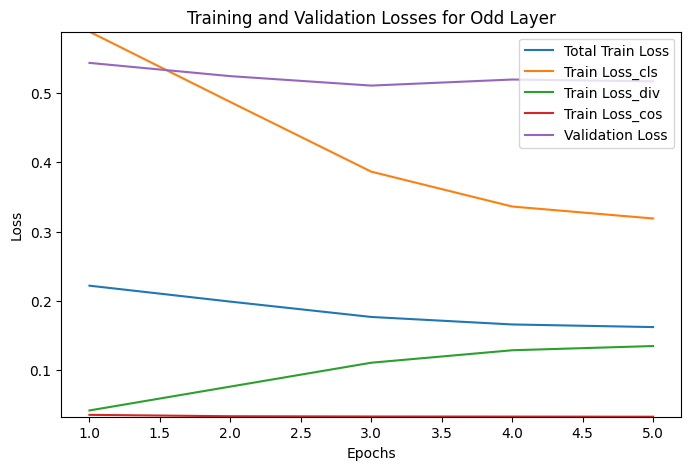

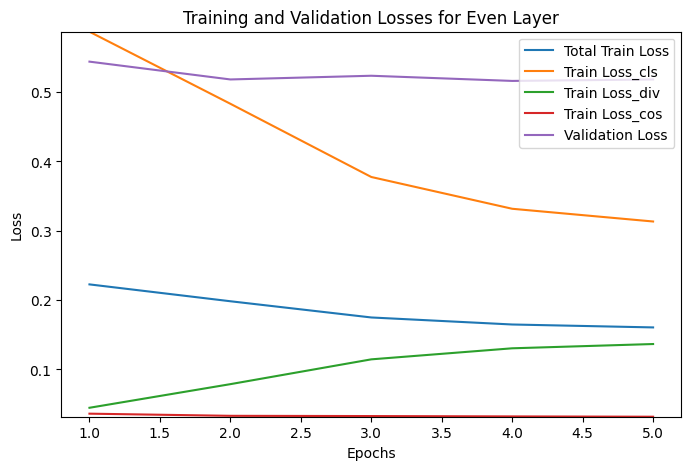

In [39]:
import matplotlib.pyplot as plt

# List of epochs
epoch_range = range(1, num_epochs + 1)

# Different loss categories
loss_categories = ['train_losses', 'train_losses_cls', 'train_losses_div', 'train_losses_cos', 'eval_losses']

# Loop through each model and plot separately
for model_label, loss_data in model_scores.items():
    plt.figure(figsize=(8, 5))  # Create a new figure for each model
    
    # Plot each type of loss
    plt.plot(epoch_range, loss_data['train_losses'], label='Total Train Loss')
    plt.plot(epoch_range, loss_data['train_losses_cls'], label='Train Loss_cls')
    plt.plot(epoch_range, loss_data['train_losses_div'], label='Train Loss_div')
    plt.plot(epoch_range, loss_data['train_losses_cos'], label='Train Loss_cos')
    plt.plot(epoch_range, loss_data['eval_losses'], label='Validation Loss')

    # Assign title and labels
    plt.title(f'Training and Validation Losses for {model_label}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    # Dynamically set y-axis range
    min_loss = min(min(loss_data[cat]) for cat in loss_categories)
    max_loss = max(max(loss_data[cat]) for cat in loss_categories)
    plt.ylim(min_loss, max_loss)

    # Add legend
    plt.legend(loc='upper right')

    # Show the figure before moving to the next model
    plt.show()

### Appendix (Teacher Model)

In [40]:
import torch
from tqdm.auto import tqdm
import torch.optim as optim
import torch.nn as nn

lr = 5e-5
#training hyperparameters
optimizer = optim.Adam(params=teacher_model.parameters(), lr=lr)

progress_bar = tqdm(range(num_training_steps))
eval_metrics = 0

for epoch in range(num_epochs):
    teacher_model.train()
    train_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        output_teacher = teacher_model(**batch)
        # cls loss 
        loss = output_teacher.loss
        train_loss += loss.item()
        loss.backward()
        # accelerator.backward(loss)
        # Step with optimizer
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    print(f'Epoch at {epoch+1}: Train loss {train_loss/len(train_dataloader):.4f}:')
    
    teacher_model.eval()
    for step, batch in enumerate(eval_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = teacher_model(**batch)
    
        predictions = outputs.logits.argmax(dim=-1)
        # predictions, references = accelerator.gather((predictions, batch["labels"]))
        metric.add_batch(
            predictions=predictions, 
            references=batch["labels"])
        
    eval_metric = metric.compute()
    eval_metrics += eval_metric['accuracy'] 
    print(f"Epoch at {epoch+1}: Test Acc {eval_metric['accuracy']:.4f}")
    
print('Avg Metric', eval_metrics/num_epochs)

  0%|          | 0/6250 [00:00<?, ?it/s]

/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` 

Epoch at 1: Train loss 0.5175:


/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` 

Epoch at 1: Test Acc 0.7080


/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` 

Epoch at 2: Train loss 0.3849:


/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` 

Epoch at 2: Test Acc 0.7770


/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` 

Epoch at 3: Train loss 0.2324:


/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` 

Epoch at 3: Test Acc 0.7790


/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` 

Epoch at 4: Train loss 0.5002:


/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` 

Epoch at 4: Test Acc 0.4910


/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` 

Epoch at 5: Train loss 0.6962:


python(56547) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
python(56550) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
python(56552) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/opt/anaconda3/envs/A6/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.util

Epoch at 5: Test Acc 0.4910
Avg Metric 0.6492


In [41]:
odd_layer_model = type(teacher_model)(configuration)
odd_layer_model = distill_bert_weights(teacher=teacher_model, student=odd_layer_model, init_method='Odd Layer')
odd_layer_model = odd_layer_model.to(device)

even_layer_model = type(teacher_model)(configuration) 
even_layer_model = distill_bert_weights(teacher=teacher_model, student=even_layer_model, init_method='Even Layer')
even_layer_model = even_layer_model.to(device)

torch.save(odd_layer_model.state_dict(), "student_odd_model")
torch.save(even_layer_model.state_dict(), "student_even_model")

## LoRA

In [42]:
from transformers import AutoModel, AutoModelForCausalLM
from peft import get_peft_config, get_peft_model, LoraConfig, TaskType
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,  
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["query", "value"],  
    bias="none",
)

model_lora = type(teacher_model)(configuration) 
model_lora = get_peft_model(model_lora, peft_config)

'NoneType' object has no attribute 'cadam32bit_grad_fp32'


/opt/anaconda3/envs/A6/lib/python3.8/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


In [43]:
import evaluate
from sklearn.metrics import accuracy_score
metric = evaluate.load("accuracy")

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    # preds have the same shape as the labels, after the argmax(-1) has been calculated
    # by preprocess_l"ogits_for_metrics but we need to shift the labels
    predictions = np.argmax(logits, axis=-1)  # Convert logits to class predictions
    accuracy = accuracy_score(labels, predictions)  # Compute accuracy
    return {"accuracy": accuracy}

In [44]:
from transformers import TrainingArguments, Trainer, default_data_collator

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
slm = "student-lora-model"
training_args = TrainingArguments(
    output_dir=slm,
    learning_rate=5e-4,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
    evaluation_strategy="steps", 
    save_strategy="steps",        
    save_steps=500,               
    eval_steps=500, 
    save_total_limit=2,  # Keeps only 2 latest checkpoints to save disk space
    report_to="none",  # Set to "wandb" or "tensorboard" if needed
    push_to_hub=False,  # Set to True if pushing model to Hugging Face
    bf16=False,
    fp16=False
)

trainer = Trainer(
    model=model_lora,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.save_model(slm)  
model_lora.save_pretrained(slm)  

print("Model saved successfully!")

  0%|          | 0/3882 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.6322, 'learning_rate': 0.0004356002060793405, 'epoch': 0.26}


  0%|          | 0/1942 [00:00<?, ?it/s]

{'eval_loss': 0.5815776586532593, 'eval_accuracy': 0.6636621169199073, 'eval_runtime': 69.2713, 'eval_samples_per_second': 56.055, 'eval_steps_per_second': 28.035, 'epoch': 0.26}


/opt/anaconda3/envs/A6/lib/python3.8/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 0.5936, 'learning_rate': 0.0003712004121586811, 'epoch': 0.52}


  0%|          | 0/1942 [00:00<?, ?it/s]

{'eval_loss': 0.5747747421264648, 'eval_accuracy': 0.6726757661601854, 'eval_runtime': 67.6585, 'eval_samples_per_second': 57.391, 'eval_steps_per_second': 28.703, 'epoch': 0.52}


/opt/anaconda3/envs/A6/lib/python3.8/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 0.5863, 'learning_rate': 0.0003068006182380216, 'epoch': 0.77}


  0%|          | 0/1942 [00:00<?, ?it/s]

{'eval_loss': 0.5643835663795471, 'eval_accuracy': 0.6713881019830028, 'eval_runtime': 66.7477, 'eval_samples_per_second': 58.174, 'eval_steps_per_second': 29.095, 'epoch': 0.77}


/opt/anaconda3/envs/A6/lib/python3.8/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 0.5774, 'learning_rate': 0.00024240082431736218, 'epoch': 1.03}


  0%|          | 0/1942 [00:00<?, ?it/s]

{'eval_loss': 0.569379448890686, 'eval_accuracy': 0.6824620139067731, 'eval_runtime': 68.7054, 'eval_samples_per_second': 56.517, 'eval_steps_per_second': 28.266, 'epoch': 1.03}


/opt/anaconda3/envs/A6/lib/python3.8/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 0.5584, 'learning_rate': 0.00017800103039670274, 'epoch': 1.29}


  0%|          | 0/1942 [00:00<?, ?it/s]

{'eval_loss': 0.549964964389801, 'eval_accuracy': 0.6922482616533608, 'eval_runtime': 69.41, 'eval_samples_per_second': 55.943, 'eval_steps_per_second': 27.979, 'epoch': 1.29}


/opt/anaconda3/envs/A6/lib/python3.8/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 0.5462, 'learning_rate': 0.00011360123647604328, 'epoch': 1.55}


  0%|          | 0/1942 [00:00<?, ?it/s]

{'eval_loss': 0.5490903258323669, 'eval_accuracy': 0.6966263198557816, 'eval_runtime': 68.9225, 'eval_samples_per_second': 56.339, 'eval_steps_per_second': 28.177, 'epoch': 1.55}


/opt/anaconda3/envs/A6/lib/python3.8/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 0.5407, 'learning_rate': 4.9201442555383824e-05, 'epoch': 1.8}


  0%|          | 0/1942 [00:00<?, ?it/s]

{'eval_loss': 0.539170503616333, 'eval_accuracy': 0.7095029616276075, 'eval_runtime': 68.4776, 'eval_samples_per_second': 56.705, 'eval_steps_per_second': 28.36, 'epoch': 1.8}


/opt/anaconda3/envs/A6/lib/python3.8/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'train_runtime': 1084.0882, 'train_samples_per_second': 57.302, 'train_steps_per_second': 3.581, 'train_loss': 0.5723215385173658, 'epoch': 2.0}


/opt/anaconda3/envs/A6/lib/python3.8/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Model saved successfully!
